In [1]:
import xarray as xr
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import regionmask
import shapefile as shp
from math import *
from matplotlib.lines import Line2D
import string
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fonction de moyenne par range d'altitude #

# Note : Le fichier orographie doit avoir les même dim spatial que le ds input

def mean_per_alt(data,ls_range,oro_file,wat = 'arome'): # data : dataset, ls_range : array des altitudes, oro_file : PGD
    ds = []
    ls_range_name = []
    std = []
    nb_points = []
    
    for i in range(0,len(ls_range)-1):
        if wat == 'arome':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('x','y')))
            std.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).std(dim=('x','y')))
        elif wat == 'S2M':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('Number_of_points')))
            std.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).std(dim=('Number_of_points')))

    ds = xr.concat(ds,dim='ZS')
    std = xr.concat(std,dim = 'ZS')
    ds['ZS']  = all_ZS
    std['ZS'] = all_ZS
    return std, ds

####################################################################################

def calc_mean(data,mean_type):

    ds_mean = []
    
    if mean_type == 'month':
        
        num_index = [9,10,11,12,1,2,3,4,5,6,7,8]
        ls_name = ['Sep', 'Oct','Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

        if str(var_name) == all_var[1] or str(var_name)== all_var[2]:
            ds_res = data.resample(time='1MS').sum(skipna = False)
        else: 
            ds_res = data.resample(time='1MS').mean()
    
        for i in range(0,len(num_index)):
            ds_month = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_month = ds_month.groupby('time.year').mean('time')
            ds_mean.append(ds_month)
            
        ds_mean = xr.concat(ds_mean,dim='month')
        ds_mean['month'] = ls_name

    if mean_type == 'season':
        
        num_index = [11,2,5,8]
        ls_name = ['SON','DJF','MAM','JJA']

        if str(var_name) == all_var[1] or str(var_name)== all_var[2]:
            ds_res = data.resample(time='Q-FEB').sum(skipna = False)
        else: 
            ds_res = data.resample(time='Q-FEB').mean()
        
        for i in range(0,len(num_index)):
            ds_season = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_season = ds_season.groupby('time.year').mean('time')
            ds_mean.append(ds_season)
       
        ds_mean = xr.concat(ds_mean,dim='season')
        ds_mean['season'] = ls_name
        
    return ds_mean

def calc_ratio_ar(data):
    ratio = (data.neige+data.graupel)/(data.accpluie+data.neige+data.graupel)
    return ratio

def calc_ratio_s2m(data):
    return (data.Snowf/(data.Rainf+data.Snowf))


def per_alt_per_massif(data, style):
    
    data_alt_massif = []
    
    if style == 'S2M':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(file_extra.massif_number==massif_nums2m[i]),ls_range,file_extra.ZS,wat = 'S2M')[1])
    
    elif style == 'arome':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(mask_massif == i), ls_range, oro)[1])

    data_alt_massif = xr.concat(data_alt_massif, dim = 'massif')
    data_alt_massif['massif'] = massif_name

    return data_alt_massif

def replace_inf_to_nan(dataset):
    dataset.to_dataframe(name = 'values').replace([np.inf,-np.inf],np.nan).to_xarray().values
    return dataset

In [3]:
##################
# INITIALISATION #
##################

data_path_arome = '/home/monteiro/STAGEIENM3/data_AROME/'
data_path_aladin = '/home/monteiro/STAGEIENM3/data_Adamont/'

all_ZS = np.arange(0,5100,300)
ls_range = [0,150,450,750,1050,1350,1650,1950,2250,2550,2850,3150,3450,3750,4050,4350,4750,4900]

massif = geopandas.read_file('/home/monteiro/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')
massif_name=np.array(massif.nom) # Nom des massifs dans l'ordre indice
massif_nums2m = np.array(massif.massif_num) # Numero des massifs dans l'ordre de l'article Arome/Safran
sf = shp.Reader('/home/monteiro/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')

##########################
# Load mask & topo arome #
##########################

name_oro = 'PGD_setgrid_subset.nc'
oro = xr.open_dataset(data_path_arome+'PGD/'+name_oro)

mask_massif = xr.open_dataset(data_path_arome+'mask_alpes/'+'mask_massif_subset.nc')
mask_massif = mask_massif['__xarray_dataarray_variable__']
mask_massif = mask_massif.rename({'X':'x','Y':'y'})

mask_all = xr.open_dataset(data_path_arome+'mask_alpes/'+'mask_all_subset.nc')
mask_all = mask_all['SFX.AVG_ZS']
mask_all = mask_all.rename({'X':'x','Y':'y'})

oro = oro['SFX.AVG_ZS']
lon = oro.lon[0,:].values
lat = oro.lat[:,0].values
oro = oro.rename({'X':'x','Y':'y'})
oro['y'] = lat
oro['x'] = lon

oro_per_massif = []
for i in range(0,23):
    oro_per_massif.append(oro.where(mask_massif == i))
oro_per_massif = xr.concat(oro_per_massif, dim = 'massif')
oro_per_massif['massif'] = massif_name

file_extra = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/file_extra.nc')

#################
# Load DS arome #
#################

all_var = ['Air temperature at 2m','Total precipitation','Fraction of solid precipitation','Snow depth']
all_unit = [' (°C)',' (kg m$^{-2}$)','',' (m)',]
unit_diff_all = [' (°C)', ' %', ' %', '(m)']
unit = all_unit[0]
var_name = all_var[0]

run = 'HISTORICAL' #RCP85, HISTORICAL or run_eval/

yr_1 = 1981
yr_2 = 2012

# Load monmean #

def load_arome_mean_ds(var_name):
    
    if var_name == all_var[0]:
        ar_monmean = xr.open_dataset(data_path_arome+'t2m/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.tas-273.15
    if var_name == all_var[1]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/monthly_mean/monmean_all_time.nc').graupel*3600
        ar_monmean_pluie = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/monthly_mean/monmean_all_time.nc').accpluie*3600
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/monthly_mean/monmean_all_time.nc').accneige*3600
        ar_monmean = (ar_monmean_grau + ar_monmean_pluie + ar_monmean_neige)
    if var_name == all_var[2]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/monthly_mean/monmean_all_time.nc').graupel
        ar_monmean = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/monthly_mean/monmean_all_time.nc').accneige
        ar_monmean['graupel'] = ar_monmean_grau
        ar_monmean['neige'] = ar_monmean_neige
        ar_monmean = ar_monmean.drop_vars(('lon_bnds', 'lat_bnds', 'time_bnds'))*3600
    if var_name == all_var[3]:
        ar_monmean = xr.open_dataset(data_path_arome+'snd/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.snd
    ar_monmean['y'] = lat
    ar_monmean['x'] = lon
    return ar_monmean

# Load daymean #

def load_arome_daily_mean(var_name):
    if var_name == all_var[0]:
        ar_monmean = xr.open_dataset(data_path_arome+'t2m/'+run+'/daily_mean/daymean_all_time.nc')
        ar_monmean = ar_monmean.tas-273.15
    if var_name == all_var[1]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/daily_mean/daymean_all_time.nc').graupel*3600
        ar_monmean_pluie = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/daily_mean/daymean_all_time.nc').accpluie*3600
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/daily_mean/daymean_all_time.nc').accneige*3600
        ar_monmean = (ar_monmean_grau + ar_monmean_pluie + ar_monmean_neige)
    if var_name == all_var[2]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/daily_mean/daymean_all_time.nc').graupel
        ar_monmean = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/daily_mean/daymean_all_time.nc')
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/daily_mean/daymean_all_time.nc').accneige
        ar_monmean['graupel'] = ar_monmean_grau
        ar_monmean['neige'] = ar_monmean_neige
        ar_monmean = ar_monmean.drop_vars(('lon_bnds', 'lat_bnds', 'time_bnds'))*3600
    if var_name == all_var[3]:
        ar_monmean = xr.open_dataset(data_path_arome+'snd/'+run+'daily_mean/daymean_all_time.nc')
        ar_monmean = ar_monmean.snd
    ar_monmean['y'] = lat
    ar_monmean['x'] = lon
    return ar_monmean

####################
# Load DS Aladin   #
####################
# Hiver 1996/1997 se situe en 1997

def load_Adam_ds(var_name):
        
    if var_name == all_var[0]:
        data = xr.open_dataset(data_path_aladin+run+'/meteo_adamont_'+run+'.nc')
        data = data.Tair-273.15
 
    elif var_name == all_var[1]:
        data = xr.open_dataset(data_path_aladin+run+'/meteo_adamont_'+run+'.nc')
        data = (data.Rainf+data.Snowf)*3600
        
    elif var_name == all_var[2]:
        data = xr.open_dataset(data_path_aladin+run+'/meteo_adamont_'+run+'.nc')
        data = (data*3600)
        
    elif var_name == all_var[3]:
        data = xr.open_dataset(data_path_aladin+run+'/pro_adamont_'+run+'.nc')
        data = data.DSN_T_ISBA
        
    return data

#################
# Load DS S2M   #
#################

def load_ds_s2m(var_name):
    
    if var_name == all_var[0]:
        data = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/Tair_1958_2018.nc')
        data = data.Tair-273.15
 
    elif var_name == all_var[1]:
        data = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/Rainf_Snowf_1958_2018.nc')
        data = (data.Rainf+data.Snowf)*3600
        
    elif var_name == all_var[2]:
        data = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/Rainf_Snowf_1958_2018.nc')
        data = (data*3600)
        
    elif var_name == all_var[3]:
        data = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/snow_1958_2018.nc')
        data = data.DSN_T_ISBA

    return data

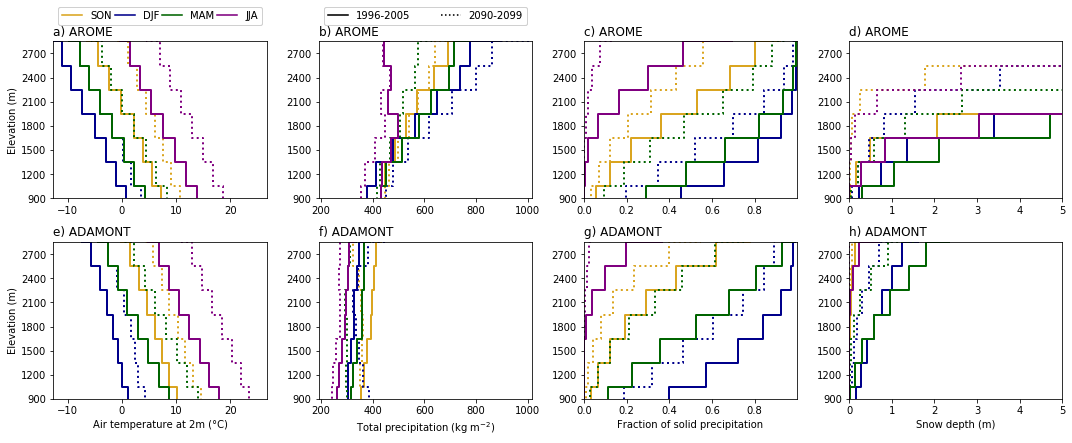

In [4]:
########################
# PROFILS ALTITUDINAUX #
########################

borne_alt = [900,3000]

fig, ax = plt.subplots(2,4,figsize=(15,6))
color = ['goldenrod','darkblue','darkgreen','purple']
linestyle = ['-', ':']
letter = [['a)','b)','c)','d)'],['e)','f)','g)','h)']]

for k in range(0,len(all_var)):
    unit = all_unit[k]
    var_name = all_var[k]

    run = 'HISTORICAL' #RCP85, HISTORICAL or run_eval/

    yr_1 = 1996
    yr_2 = 2005

    if var_name == all_var[2]:    
        ar_season_hist = calc_ratio_ar(per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        adam_season_hist = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_season_hist)))
    else:
        ar_season_hist = per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2))
        adam_season_hist = per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_season_hist))

    run = 'RCP85' #RCP85, HISTORICAL or run_eval/

    yr_1 = 2090
    yr_2 = 2099

    if var_name == all_var[2]:    
        ar_season_RCP85 = calc_ratio_ar(per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        adam_season_RCP85 = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_season_RCP85)))
    else:
        ar_season_RCP85 = per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2))
        adam_season_RCP85 = per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_season_RCP85))
    
    AR_hist = ar_season_hist.mean(dim = ('year','massif')).sel(ZS = slice(0,3000))
    AR_RCP85 = ar_season_RCP85.mean(dim = ('year','massif')).sel(ZS = slice(0,3000))

    ADAM_hist = adam_season_hist.mean(dim = ('year','massif')).sel(ZS = slice(0,3000))
    ADAM_RCP85 = adam_season_RCP85.mean(dim = ('year','massif')).sel(ZS = slice(0,3000))
    
    xlim_inf = np.nanmin([AR_hist,AR_RCP85,ADAM_hist,ADAM_RCP85])
    xlim_sup = np.nanmax([AR_hist,AR_RCP85,ADAM_hist,ADAM_RCP85])
    
    for i in range(0,len(AR_hist.season)):
        ax[0][k].step(AR_hist.sel(season = AR_hist.season[i]),AR_hist.ZS-150, where='pre', linestyle = linestyle[0],linewidth=2, color = color[i])
        ax[0][k].step(AR_RCP85.sel(season = AR_RCP85.season[i]),AR_RCP85.ZS-150, where='pre', linestyle = linestyle[1],linewidth=2, color = color[i])
        if k == 0:
            ax[0][k].set_ylabel('Elevation (m)')
        ax[0][k].set_yticks(AR_RCP85.ZS)
        ax[0][k].set_ylim(borne_alt[0],borne_alt[1]-150)
        ax[0][k].set_title(letter[0][k]+' AROME', loc = 'left')
        ax[0][k].set_xlim(xlim_inf,xlim_sup)
    if var_name == all_var[3]:
        ax[0][3].set_xlim(0,5)
        
    for i in range(0,len(ADAM_hist.season)):
        ax[1][k].step(ADAM_hist.sel(season = ADAM_hist.season[i]),ADAM_hist.ZS-150, where='pre', linestyle = linestyle[0],linewidth=2, color = color[i])
        ax[1][k].step(ADAM_RCP85.sel(season = ADAM_RCP85.season[i]),ADAM_RCP85.ZS-150, where='pre', linestyle = linestyle[1],linewidth=2, color = color[i])
        if k == 0:
            ax[1][k].set_ylabel('Elevation (m)')
        ax[1][k].set_yticks(ADAM_RCP85.ZS)
        ax[1][k].set_xlabel(var_name+unit)
        ax[1][k].set_ylim(borne_alt[0],borne_alt[1]-150)
        ax[1][k].set_title(letter[1][k]+' ADAMONT', loc = 'left')
        ax[1][k].set_xlim(xlim_inf,xlim_sup)
    if var_name == all_var[3]:
        ax[1][3].set_xlim(0,5)
        
legend2 = ax[0][1].legend([Line2D([0],[0],color = 'k', linestyle = linestyle[0]),Line2D([0],[0],color = 'k', linestyle = linestyle[1])],['1996-2005', '2090-2099'], mode = 'expand',ncol = 2,bbox_to_anchor=(0., 1.15, 1., .102), prop={'size': 10})
ax[0][1].add_artist(legend2)

legend3 = ax[0][0].legend([Line2D([0],[0],color = color[0], linestyle = linestyle[0]),Line2D([0],[0],color = color[1], linestyle = linestyle[0]),Line2D([0],[0],color = color[2], linestyle = linestyle[0]),Line2D([0],[0],color = color[3], linestyle = linestyle[0])], ['SON','DJF','MAM','JJA'], mode = 'expand',ncol = 4,bbox_to_anchor=(0., 1.15, 1., .102), prop={'size': 10})
ax[0][0].add_artist(legend3)

plt.tight_layout()

plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/Resultat_3/Profils_alt.pdf',bbox_inches = 'tight')

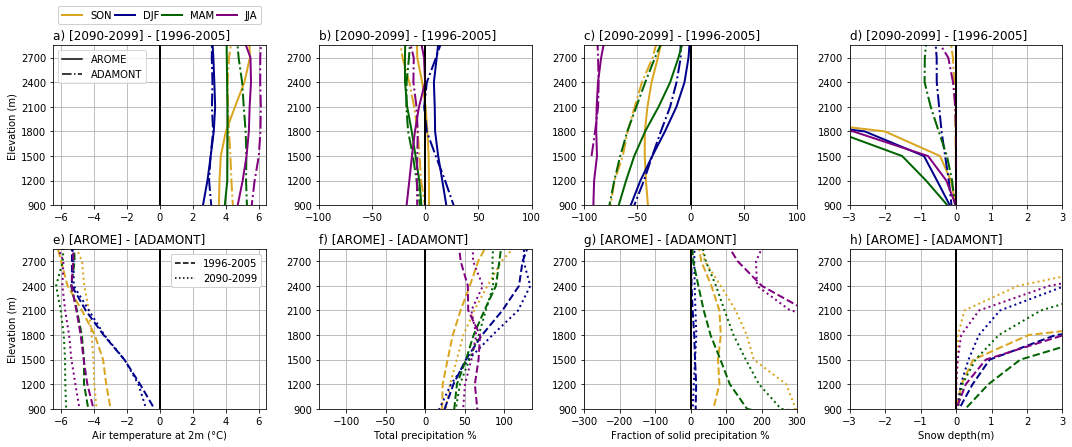

In [5]:
#############################
# PROFILS ALTITUDINAUX DIFF #
#############################

borne_alt = [900,3000]

fig, ax = plt.subplots(2,4,figsize=(15,6))
color = ['goldenrod','darkblue','darkgreen','purple']
linestyle = ['-', '-.','--',':']
letter = [['a)','b)','c)','d)'],['e)','f)','g)','h)']]

for k in range(0,len(all_var)):
    unit = all_unit[k]
    var_name = all_var[k]
    unit_diff = unit_diff_all[k]
    run = 'HISTORICAL' #RCP85, HISTORICAL or run_eval/

    yr_1 = 1996
    yr_2 = 2005

    if var_name == all_var[2]:    
        ar_season_hist = calc_ratio_ar(per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        adam_season_hist = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_season_hist)))
    else:
        ar_season_hist = per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2))
        adam_season_hist = per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_season_hist))

    run = 'RCP85' #RCP85, HISTORICAL or run_eval/

    yr_1 = 2090
    yr_2 = 2099

    if var_name == all_var[2]:    
        ar_season_RCP85 = calc_ratio_ar(per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        adam_season_RCP85 = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_season_RCP85)))
    else:
        ar_season_RCP85 = per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2))
        adam_season_RCP85 = per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_season_RCP85))

    AR_hist = ar_season_hist.mean(dim = ('year','massif')).sel(ZS = slice(0,3000))
    AR_RCP85 = ar_season_RCP85.mean(dim = ('year','massif')).sel(ZS = slice(0,3000))
    
    ADAM_hist = adam_season_hist.mean(dim = ('year','massif')).sel(ZS = slice(0,3000))
    ADAM_RCP85 = adam_season_RCP85.mean(dim = ('year','massif')).sel(ZS = slice(0,3000))
    
    if var_name == all_var[0] or var_name == all_var[3]:
        diff_AROME = AR_RCP85 - AR_hist
        diff_ADAMONT = ADAM_RCP85 - ADAM_hist
        diff_model_hist = AR_hist - ADAM_hist
        diff_model_RCP85 = AR_RCP85 - ADAM_RCP85
    else:
        diff_AROME = replace_inf_to_nan((AR_RCP85 - AR_hist)/AR_hist*100)
        diff_ADAMONT = replace_inf_to_nan((ADAM_RCP85 - ADAM_hist)/ADAM_hist*100)
        diff_model_hist = replace_inf_to_nan((AR_hist - ADAM_hist)/ADAM_hist*100)
        diff_model_RCP85 = replace_inf_to_nan((AR_RCP85 - ADAM_RCP85)/ADAM_RCP85*100)
    
    xlim_inf = np.nanmin([diff_AROME,diff_ADAMONT,diff_model_hist,diff_model_RCP85])
    xlim_sup = np.nanmax([diff_AROME,diff_ADAMONT,diff_model_hist,diff_model_RCP85])
    xlim = max(np.abs(xlim_inf),np.abs(xlim_sup))
    if xlim > 100 and var_name == all_var[2]:
        xlim = 300

    for i in range(0,len(diff_AROME.season)):
        ax[0][k].plot(diff_AROME.sel(season = diff_AROME.season[i]),diff_AROME.ZS, linestyle = linestyle[0],linewidth=2,color = color[i])
        ax[0][k].plot(diff_ADAMONT.sel(season = diff_ADAMONT.season[i]),diff_ADAMONT.ZS, linestyle = linestyle[1],linewidth=2, color = color[i])
        if k == 0:
            ax[0][k].set_ylabel('Elevation (m)')
        ax[0][k].set_yticks(diff_AROME.ZS)
        ax[0][k].set_ylim(borne_alt[0],borne_alt[1]-150)
        ax[0][k].set_title(letter[0][k]+' [2090-2099] - [1996-2005]', loc = 'left')
        ax[0][k].set_xlim(-xlim,xlim)
        ax[0][k].plot([0]*len(diff_model_hist.ZS), diff_model_hist.ZS, linestyle = '-', color = 'k')

        if var_name == all_var[3]:
            ax[0][3].set_xlim(-3,3)
        if var_name == all_var[1] or var_name == all_var[2] : 
            ax[0][k].set_xlim(-100,100)
        ax[0][k].grid(True)
        
    for i in range(0,len(diff_AROME.season)):        
        ax[1][k].plot(diff_model_hist.sel(season = diff_model_hist.season[i]),diff_model_hist.ZS, linestyle = linestyle[2],linewidth=2, color = color[i])
        ax[1][k].plot(diff_model_RCP85.sel(season = diff_model_RCP85.season[i]),diff_model_RCP85.ZS, linestyle = linestyle[3],linewidth=2, color = color[i])
        if k == 0:
            ax[1][k].set_ylabel('Elevation (m)')
        ax[1][k].set_yticks(diff_model_hist.ZS)
        ax[1][k].set_xlabel(var_name+unit_diff)
        ax[1][k].set_ylim(borne_alt[0],borne_alt[1]-150)
        ax[1][k].set_title(letter[1][k]+' [AROME] - [ADAMONT]', loc = 'left')
        ax[1][k].set_xlim(-xlim,xlim)
        ax[1][k].plot([0]*len(diff_model_hist.ZS), diff_model_hist.ZS, linestyle = '-', color = 'k')

        if var_name == all_var[3]:
            ax[1][3].set_xlim(-3,3)
        ax[1][k].grid(True)

lines = ax[0][0].get_lines()
legend1 = ax[0][0].legend([Line2D([0],[0],color = 'k', linestyle = linestyle[0]),Line2D([0],[0],color = 'k', linestyle = linestyle[1])], ['AROME', 'ADAMONT'])
ax[0][0].add_artist(legend1)

legend2 = ax[1][0].legend([Line2D([0],[0],color = 'k', linestyle = linestyle[2]),Line2D([0],[0],color = 'k', linestyle = linestyle[3])],['1996-2005', '2090-2099'])
ax[1][0].add_artist(legend2)


legend3 = ax[0][0].legend([lines[k] for k in [0,3,6,9]], ['SON','DJF','MAM','JJA'], mode = 'expand',ncol = 4,bbox_to_anchor=(0., 1.1, 1., .102))
ax[0][0].add_artist(legend3)

plt.tight_layout()
plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/Resultat_3/Profils_alt_diff.pdf',bbox_inches = 'tight')

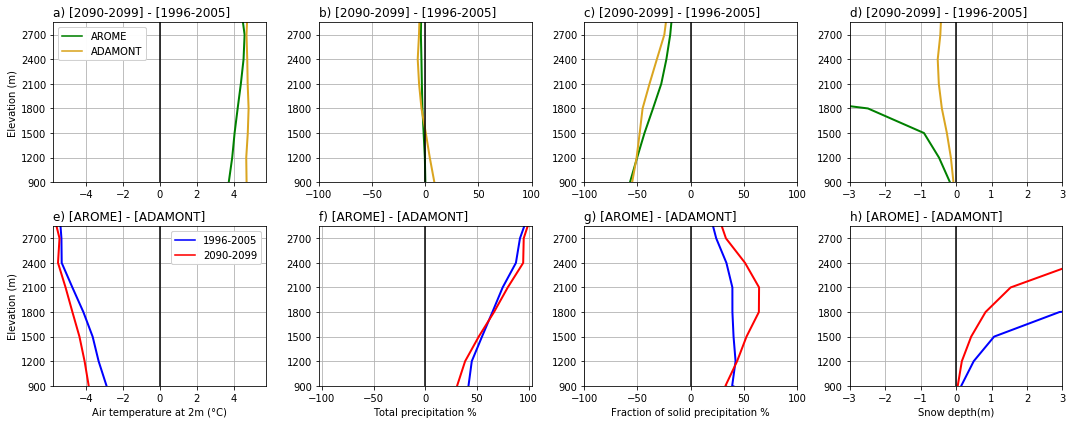

In [4]:
#################################
# PROFILS ALTITUDINAUX ANNUELLE #
#################################

borne_alt = [900,3000]

fig, ax = plt.subplots(2,4,figsize=(15,6))
color = ['blue','green','goldenrod', 'blue', 'red']
linestyle = ['-', '-','-','-']
letter = [['a)','b)','c)','d)'],['e)','f)','g)','h)']]

for k in range(0,len(all_var)):
    unit = all_unit[k]
    var_name = all_var[k]
    unit_diff = unit_diff_all[k]
    run = 'HISTORICAL' #RCP85, HISTORICAL or run_eval/

    yr_1 = '1996'
    yr_2 = '2005'

    if var_name == all_var[2]:    
        ar_hist = calc_ratio_ar(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(),style = 'arome').sel(time = slice(yr_1,yr_2)))
        adam_hist = calc_ratio_s2m(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(),style = 'S2M').sel(time = slice(yr_1,yr_2)).where(~np.isnan(ar_hist)))

    elif var_name == all_var[1]:
        ar_hist = per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(),style = 'arome').sel(time = slice(yr_1,yr_2))
        adam_hist = per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(),style = 'S2M').sel(time = slice(yr_1,yr_2)).where(~np.isnan(ar_hist))

    elif var_name == all_var[3]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr_1+'-11',yr_2+'-04')).resample(time = '6MS').mean(), style = 'arome')
        ar_hist = a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean().sel(time = slice(yr_1,yr_2))
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr_1+'-11',yr_2+'-04')).resample(time = '6MS').mean(), style = 'S2M')
        adam_hist = a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean().sel(time = slice(yr_1,yr_2)).where(~np.isnan(ar_hist))

    elif var_name == all_var[0]:
        ar_hist = per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').mean(),style = 'arome').sel(time = slice(yr_1,yr_2))
        adam_hist = per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').mean(),style = 'S2M').sel(time = slice(yr_1,yr_2)).where(~np.isnan(ar_hist))

    run = 'RCP85' #RCP85, HISTORICAL or run_eval/

    yr_1 = '2090'
    yr_2 = '2099'

    if var_name == all_var[2]:    
        ar_RCP85 = calc_ratio_ar(per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(),style = 'arome').sel(time = slice(yr_1,yr_2)))
        adam_RCP85 = calc_ratio_s2m(per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(),style = 'S2M').sel(time = slice(yr_1,yr_2)).where(~np.isnan(ar_RCP85)))

    elif var_name == all_var[1]:
        ar_RCP85 = per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').sum(),style = 'arome').sel(time = slice(yr_1,yr_2))
        adam_RCP85 = per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').sum(),style = 'S2M').sel(time = slice(yr_1,yr_2)).where(~np.isnan(ar_RCP85))

    elif var_name == all_var[3]:
        a = per_alt_per_massif(load_arome_mean_ds(var_name).sel(time=slice(yr_1+'-11',yr_2+'-04')).resample(time = '6MS').mean(), style = 'arome')
        ar_RCP85 = a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean().sel(time = slice(yr_1,yr_2))
        a = per_alt_per_massif(load_Adam_ds(var_name).sel(time=slice(yr_1+'-11',yr_2+'-04')).resample(time = '6MS').mean(), style = 'S2M')
        adam_RCP85 = a.sel(time = a.time.dt.month.isin(11)).resample(time = '1Y').mean().sel(time = slice(yr_1,yr_2)).where(~np.isnan(ar_RCP85))

    elif var_name == all_var[0]:
        ar_RCP85 = per_alt_per_massif(load_arome_mean_ds(var_name).resample(time = '1Y').mean(),style = 'arome').sel(time = slice(yr_1,yr_2))
        adam_RCP85 = per_alt_per_massif(load_Adam_ds(var_name).resample(time = '1Y').mean(),style = 'S2M').sel(time = slice(yr_1,yr_2)).where(~np.isnan(ar_RCP85))

    AR_hist = ar_hist.mean(dim = ('time','massif')).sel(ZS = slice(0,3000))
    AR_RCP85 = ar_RCP85.mean(dim = ('time','massif')).sel(ZS = slice(0,3000))
    
    ADAM_hist = adam_hist.mean(dim = ('time','massif')).sel(ZS = slice(0,3000))
    ADAM_RCP85 = adam_RCP85.mean(dim = ('time','massif')).sel(ZS = slice(0,3000))
    
    if var_name == all_var[0] or var_name == all_var[3]:
        diff_AROME = AR_RCP85 - AR_hist
        diff_ADAMONT = ADAM_RCP85 - ADAM_hist
        diff_model_hist = AR_hist - ADAM_hist
        diff_model_RCP85 = AR_RCP85 - ADAM_RCP85
    else:
        diff_AROME = replace_inf_to_nan((AR_RCP85 - AR_hist)/AR_hist*100)
        diff_ADAMONT = replace_inf_to_nan((ADAM_RCP85 - ADAM_hist)/ADAM_hist*100)
        diff_model_hist = replace_inf_to_nan((AR_hist - ADAM_hist)/ADAM_hist*100)
        diff_model_RCP85 = replace_inf_to_nan((AR_RCP85 - ADAM_RCP85)/ADAM_RCP85*100)
    
    xlim_inf = np.nanmin([diff_AROME,diff_ADAMONT,diff_model_hist,diff_model_RCP85])
    xlim_sup = np.nanmax([diff_AROME,diff_ADAMONT,diff_model_hist,diff_model_RCP85])
    xlim = max(np.abs(xlim_inf),np.abs(xlim_sup))
    if xlim > 100 and var_name == all_var[2]:
        xlim = 100

    ax[0][k].plot(diff_AROME,diff_AROME.ZS, linestyle = linestyle[0],linewidth=2,color = color[1])
    ax[0][k].plot(diff_ADAMONT,diff_ADAMONT.ZS, linestyle = linestyle[1],linewidth=2, color = color[2])
    if k == 0:
        ax[0][k].set_ylabel('Elevation (m)')
    ax[0][k].set_yticks(diff_AROME.ZS)
    ax[0][k].set_ylim(borne_alt[0],borne_alt[1]-150)
    ax[0][k].set_title(letter[0][k]+' [2090-2099] - [1996-2005]', loc = 'left')
    ax[0][k].set_xlim(-xlim,xlim)
    ax[0][k].plot([0]*len(diff_model_hist.ZS), diff_model_hist.ZS, linestyle = '-', color = 'k')

    if var_name == all_var[3]:
        ax[0][3].set_xlim(-3,3)
    if var_name == all_var[1] or var_name == all_var[2] : 
        ax[0][k].set_xlim(-100,100)
    ax[0][k].grid(True)

    ax[1][k].plot(diff_model_hist,diff_model_hist.ZS, linestyle = linestyle[2],linewidth=2, color = color[3])
    ax[1][k].plot(diff_model_RCP85,diff_model_RCP85.ZS, linestyle = linestyle[3],linewidth=2, color = color[4])
    if k == 0:
        ax[1][k].set_ylabel('Elevation (m)')
    ax[1][k].set_yticks(diff_model_hist.ZS)
    ax[1][k].set_xlabel(var_name+unit_diff)
    ax[1][k].set_ylim(borne_alt[0],borne_alt[1]-150)
    ax[1][k].set_title(letter[1][k]+' [AROME] - [ADAMONT]', loc = 'left')
    ax[1][k].set_xlim(-xlim,xlim)
    ax[1][k].plot([0]*len(diff_model_hist.ZS), diff_model_hist.ZS, linestyle = '-', color = 'k')

    if var_name == all_var[3]:
        ax[1][3].set_xlim(-3,3)
    ax[1][k].grid(True)

lines = ax[0][0].get_lines()
legend1 = ax[0][0].legend([Line2D([0],[0],color = color[1], linestyle = linestyle[0]),Line2D([0],[0],color = color[2], linestyle = linestyle[1])], ['AROME', 'ADAMONT'])
ax[0][0].add_artist(legend1)

legend2 = ax[1][0].legend([Line2D([0],[0],color = color[3], linestyle = linestyle[2]),Line2D([0],[0],color = color[4], linestyle = linestyle[3])],['1996-2005', '2090-2099'])
ax[1][0].add_artist(legend2)



plt.tight_layout()
plt.savefig('/home/monteiro/Bureau/Profils_alt_diff_annuelles.png',bbox_inches = 'tight')

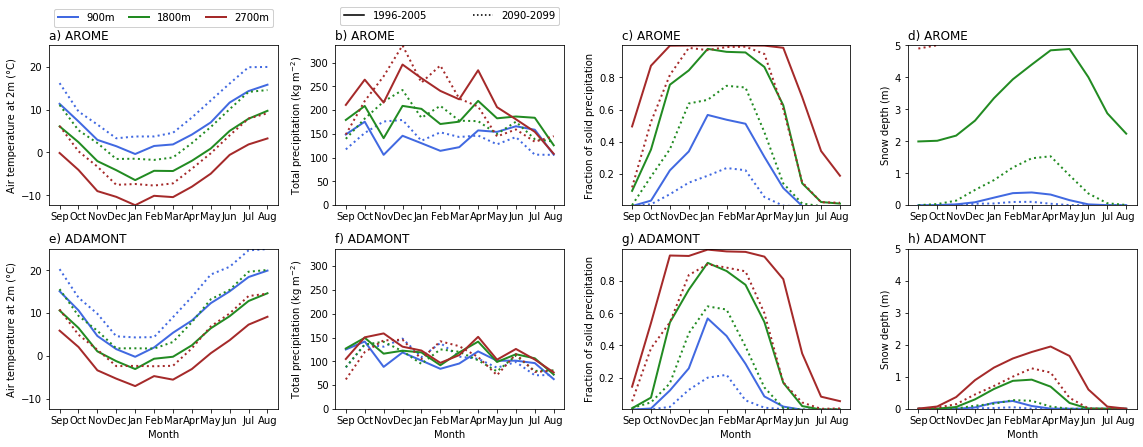

In [76]:
#########################
# Evolutions mensuelles #
#########################
fig, ax = plt.subplots(2,4,figsize=(16,6))
letter = [['a)','b)','c)','d)'],['e)','f)','g)','h)']]

plot_ZS_range = np.arange(900,3600,900)
color = ['royalblue','forestgreen', 'brown']
linestyle = ['-', ':']

for k in range(0,len(all_var)):
    
    unit = all_unit[k]
    var_name = all_var[k]

    run = 'HISTORICAL' #RCP85, HISTORICAL or run_eval/

    yr_1 = 1996
    yr_2 = 2005

    if var_name == all_var[2]:    
        ar_month_hist = calc_ratio_ar(per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        adam_month_hist = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_month_hist)))
    else:
        ar_month_hist = per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2))
        adam_month_hist = per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_month_hist))

    run = 'RCP85' #RCP85, HISTORICAL or run_eval/

    yr_1 = 2090
    yr_2 = 2099

    if var_name == all_var[2]:    
        ar_month_RCP85 = calc_ratio_ar(per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        adam_month_RCP85 = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_month_RCP85)))
    else:
        ar_month_RCP85 = per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2))
        adam_month_RCP85 = per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_month_RCP85))
    
    for i in range(0,len(plot_ZS_range)):
        alt_i = plot_ZS_range[i]
        lim_inf = []
        lim_sup = []
        
        ar_month_hist_a = ar_month_hist.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        ar_month_RCP85_a = ar_month_RCP85.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        adam_month_hist_a = adam_month_hist.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        adam_month_RCP85_a = adam_month_RCP85.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        
        lim_inf.append(np.nanmin([ar_month_hist_a,adam_month_hist_a,ar_month_RCP85_a,adam_month_RCP85_a]))
        lim_sup.append(np.nanmax([ar_month_hist_a,adam_month_hist_a,ar_month_RCP85_a,adam_month_RCP85_a]))
    
    lim_inf = np.min(lim_inf)
    lim_sup = np.max(lim_sup)

    ######################################

    for i in range(0,len(plot_ZS_range)):
        
        alt_i = plot_ZS_range[i]

        ar_month_hist_a = ar_month_hist.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        ar_month_RCP85_a = ar_month_RCP85.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        
        ax[0][k].plot(ar_month_hist_a.month,ar_month_hist_a, linestyle = linestyle[0], linewidth = 2, color = color[i])
        ax[0][k].plot(ar_month_RCP85_a.month,ar_month_RCP85_a, linestyle = linestyle[1], linewidth = 2, color = color[i])
        ax[0][k].set_ylabel(var_name+unit)
        ax[0][k].set_title(letter[0][k]+' AROME', loc = 'left')
        ax[0][k].set_ylim(lim_inf,lim_sup)
        
    if var_name == all_var[0]:
        ax[0][k].set_ylim(lim_inf,25)
    if var_name == all_var[1]:
        ax[0][k].set_ylim(0,lim_sup)
    if var_name == all_var[3]:
        ax[0][3].set_ylim(0,5)
    
    ############################################
    
    for i in range(0,len(plot_ZS_range)):
        
        alt_i = plot_ZS_range[i]

        adam_month_hist_a = adam_month_hist.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        adam_month_RCP85_a = adam_month_RCP85.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')

        ax[1][k].plot(adam_month_hist_a.month,adam_month_hist_a, linestyle = linestyle[0],linewidth=2, color = color[i])
        ax[1][k].plot(adam_month_RCP85_a.month,adam_month_RCP85_a, linestyle = linestyle[1],linewidth=2, color = color[i])
        ax[1][k].set_ylabel(var_name+unit)
        ax[1][k].set_xlabel('Month')
        ax[1][k].set_title(letter[1][k]+' ADAMONT', loc = 'left')
        ax[1][k].set_ylim(lim_inf,lim_sup)

    if var_name == all_var[0]:
        ax[1][k].set_ylim(lim_inf,25)
    if var_name == all_var[1]:
        ax[1][k].set_ylim(0,lim_sup)
    if var_name == all_var[3]:
        ax[1][3].set_ylim(0,5)
        
lines = ax[0][0].get_lines() 
legend2 = ax[0][1].legend([Line2D([0],[0],color = 'k', linestyle = linestyle[0]),Line2D([0],[0],color = 'k', linestyle = linestyle[1])],['1996-2005', '2090-2099'], mode = 'expand',ncol = 2,bbox_to_anchor=(0., 1.17, 1., .102), prop={'size': 10})
ax[0][1].add_artist(legend2)

legend3 = ax[0][0].legend([lines[k] for k in [0,2,4]], ['900m','1800m','2700m'], mode = 'expand',ncol = 4,bbox_to_anchor=(0., 1.16, 1., .102), prop={'size': 10})
ax[0][0].add_artist(legend3)

plt.tight_layout()
plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/Resultat_3/Distrib_mensuelles.pdf',bbox_inches = 'tight')

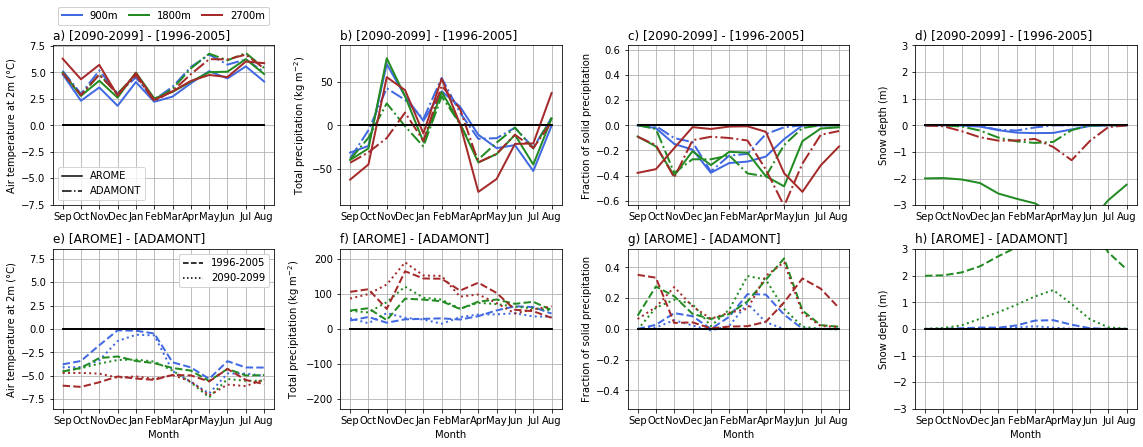

In [63]:
##############################
# Evolutions mensuelles diff #
##############################

plot_ZS_range = np.arange(900,3600,900)
fig, ax = plt.subplots(2,4,figsize=(16,6))
color = ['royalblue','forestgreen', 'brown']
linestyle = ['-', '-.','--',':']
letter = [['a)','b)','c)','d)'],['e)','f)','g)','h)']]

for k in range(0,len(all_var)):
    
    unit = all_unit[k]
    var_name = all_var[k]

    run = 'HISTORICAL' #RCP85, HISTORICAL or run_eval/

    yr_1 = 1996
    yr_2 = 2005

    if var_name == all_var[2]:    
        ar_month_hist = calc_ratio_ar(per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        adam_month_hist = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_month_hist)))
    else:
        ar_month_hist = per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2))
        adam_month_hist = per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_month_hist))

    run = 'RCP85' #RCP85, HISTORICAL or run_eval/

    yr_1 = 2090
    yr_2 = 2099

    if var_name == all_var[2]:    
        ar_month_RCP85 = calc_ratio_ar(per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        adam_month_RCP85 = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_month_RCP85)))
    else:
        ar_month_RCP85 = per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2))
        adam_month_RCP85 = per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(ar_month_RCP85))
    
    for i in range(0,len(plot_ZS_range)):
        alt_i = plot_ZS_range[i]
        
        diff_lim_year = []
        diff_lim_data = []

        ar_month_hist_a = ar_month_hist.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        ar_month_RCP85_a = ar_month_RCP85.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        adam_month_hist_a = adam_month_hist.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        adam_month_RCP85_a = adam_month_RCP85.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        
        diff_lim_year.append(np.abs(ar_month_RCP85_a - ar_month_hist_a))
        diff_lim_data.append(np.abs(ar_month_RCP85_a - adam_month_RCP85_a))

    diff_lim_year = np.nanmax(diff_lim_year)*1.2
    diff_lim_data = np.nanmax(diff_lim_data)*1.2


    if var_name == all_var[3]:
        diff_lim_year = 4
        diff_lim_data = 9

    ######################################

    for i in range(0,len(plot_ZS_range)):
        
        alt_i = plot_ZS_range[i]

        ar_month_hist_a = ar_month_hist.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        ar_month_RCP85_a = ar_month_RCP85.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        adam_month_hist_a = adam_month_hist.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        adam_month_RCP85_a = adam_month_RCP85.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')

        diff_ar = ar_month_RCP85_a - ar_month_hist_a
        diff_adam = adam_month_RCP85_a - adam_month_hist_a
        
        ax[0][k].plot(diff_ar.month,diff_ar, linestyle = linestyle[0],linewidth=2, color = color[i])
        ax[0][k].plot(diff_adam.month,diff_adam, linestyle = linestyle[1],linewidth=2, color = color[i])
        ax[0][k].plot(diff_adam.month,len(diff_adam.month)*[0],'k')
        ax[0][k].set_ylabel(var_name+unit)
        ax[0][k].set_title(letter[0][k]+' [2090-2099] - [1996-2005]', loc = 'left')
        ax[0][k].set_ylim(-diff_lim_year,diff_lim_year)
        ax[0][k].grid()
        
    if var_name == all_var[3]:
        ax[0][3].set_ylim(-3,3)

    ############################################
    
    for i in range(0,len(plot_ZS_range)):
        
        alt_i = plot_ZS_range[i]

        ar_month_hist_a = ar_month_hist.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        ar_month_RCP85_a = ar_month_RCP85.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        adam_month_hist_a = adam_month_hist.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        adam_month_RCP85_a = adam_month_RCP85.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
        
        diff_data_hist = ar_month_hist_a - adam_month_hist_a
        diff_data_RCP85 = ar_month_RCP85_a - adam_month_RCP85_a
    
        ax[1][k].plot(diff_data_hist.month,diff_data_hist, linestyle = linestyle[2], linewidth = 2, color = color[i])
        ax[1][k].plot(diff_data_RCP85.month,diff_data_RCP85, linestyle = linestyle[3], linewidth = 2, color = color[i])
        ax[1][k].plot(diff_data_RCP85.month,len(diff_data_RCP85.month)*[0],'k')
        ax[1][k].set_ylabel(var_name+unit)
        ax[1][k].set_xlabel('Month')
        ax[1][k].set_title(letter[1][k]+' [AROME] - [ADAMONT]', loc = 'left')
        ax[1][k].set_ylim(-diff_lim_data,diff_lim_data)
        ax[1][k].grid()
        
    if var_name == all_var[3]:
        ax[1][3].set_ylim(-3,3)
        
lines = ax[0][0].get_lines()
legend1 = ax[0][0].legend([Line2D([0],[0],color = 'k', linestyle = linestyle[0]),Line2D([0],[0],color = 'k', linestyle = linestyle[1])], ['AROME', 'ADAMONT'])
ax[0][0].add_artist(legend1)

legend2 = ax[1][0].legend([Line2D([0],[0],color = 'k', linestyle = linestyle[2]),Line2D([0],[0],color = 'k', linestyle = linestyle[3])],['1996-2005', '2090-2099'])
ax[1][0].add_artist(legend2)

legend3 = ax[0][0].legend([lines[k] for k in [0,3,6]], ['900m','1800m','2700m'], mode = 'expand',ncol = 4,bbox_to_anchor=(0., 1.17, 1., .102), prop={'size': 10})
ax[0][0].add_artist(legend3)

plt.tight_layout()
plt.savefig('/home/monteiro/Bureau/Rapport STAGE IENM3/Resultat_3/Distrib_mensuelles_diff.pdf',bbox_inches = 'tight')